[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RikVoorhaar/optimization-II-2021/blob/master/notebooks/week7.ipynb)

# Week 9

This is the fourth Python programming homework for this course. You can do this homework either on Google colab, or on your own machine (after installing conda). Some general instructions for the exercises:

- In the description of every exercise we mention which functions you should use, and there will be a link to the relevant documentation. You are strongly encouraged to read the documentation, especially if you are not sure what the function does. 

- Each exersice consists of finishing some partially written code. The code you wrote is then automatically tested using a few `assert` statements. This is for your convenience, and you are requested __not to alter the tests__. If your code conforms to the instructions, and none of the tests throw an error, your answer is very likely to be correct. 

- It is possible to solve each exercise in no more than 10-20 lines of code, and most only need 2-3 lines. If your solution is much longer, you should try to make it shorter. In particular, don't forget that using vectorized `numpy` and `scipy` functions tends to produce shorter and much faster code than using nested Python `for` loops. 

- Before handing in, be sure to restart the IPython kernel (in colab: Runtime $\to$ Run all) and run the entire notebook top-to-bottom and check that none of the cells throw an error. 

Now we begin by running the cell below. Google colab by default uses an outdated version of CVXPY, and so we will need to update it. This may take about a minute, but this is only performed once per session. If you're running this notebook on a local python installation, make sure that this cell does not throw any errors. If it does, you will need to install additional packages. You can do this by using `pip` from the command line.

In [17]:
from importlib_metadata import version

if version('cvxpy')<'1.1.0':
   !pip install --upgrade cvxpy

import cvxpy as cp
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (9, 6)
import numpy as np
import pandas as pd
import scipy
import sklearn
import sympy

import warnings
warnings.filterwarnings('ignore') # don't display irrelevant deprecation warnings

## Exercise 1: Separating hyperplanes

In this series, we will study support vector machines (SVM). We can think of an SVM as a function $f(x)\colon \mathbb R^n\to\{-1,1\}$ that satisfies
$$
f(x) = \operatorname{sgn}(a^\top x-b)
$$

where $a \in\mathbb R^n$ and $b\in\mathbb R$ are fixed (but learned from data) and $\operatorname{sgn}$ is the sign function. It has values $1$ on one side of the hyperplane defined by $a^\top x = b$, and value $-1$ on the other side. 

A set of points $X=(x_1,\dots,x_N)\subset\mathbb R^n$ and labels $Y=(y_1,\dots,y_N)\subset \{-1,1\}$ is called _separable_ if there exists a hyperplane that separates the points with label $-1$ from those with label $+1$. In this case, the labels $Y$ can be perfectly modeled using an SVM. Recall from the lectures that we can find a good separating hyperplane (with so-called maximal margin) by solving the following QCQP
$$
\begin{array}{ll}
\text{maximize} & t \\
\text{subject to} &y_i(a^\top x_i-b)\geq t,\qquad \forall i\\
& \|a\|_2^2\leq 1 \\ 
& t\geq 0
\end{array}
$$

Here the optimal value of $t$ is the minimum distance of any point to the hyperplane. If there is no separating hyperplane, the only feasible point is $a=0,b=0,t=0$. 

___

> Write a function `separating_hyperplane(X,Y)` that finds a separating hyperplane for the points `X` and labels `Y` if it exists. It should also return the minimal distance between the hyperplane and the points. 
> It should return the data as a tuple `(a,b,t)`, as defined above. If there is no separating hyperplane, then these parameters should all be `None`.  

___  

Tips:  

- In the constraint above, use `cp.multiply` to multiply by `Y`. Using `*` will result in matrix multiplication instead.  

- If there is a separating hyperplane, then always $\|a\|=1$. If not then $a=0,b=0,t=0$ is the only feasible point, and CVXPY will return a point _close to this_. You can use this to check if a separating hyperplane exists.

In [18]:
# First some code for generating separable data,
# and plotting the hyperplane in the 2-dimensional case


def gen_separable_data(a, b, N=100, separation_factor=1 / 10):
    a = np.array(a)
    n = len(a)
    X = np.random.uniform(low=-1, high=1, size=(n, N))
    Y = a @ X > b
    X[:, Y] = (X[:, Y].T + a * separation_factor / np.linalg.norm(a)).T
    X[:, ~Y] = (X[:, ~Y].T - a * separation_factor / np.linalg.norm(a)).T
    Y = 2 * Y.astype(int) - 1
    return X, Y


def plot_separating_hyperplane2D(X, Y, a, b):
    # Find two point on the hyperplane (line) far apart
    x0 = a * b / np.linalg.norm(a) ** 2  # This point always lies on the line
    a_orth = np.array([-a[1], a[0]])  # Direction orthogonal to a
    x1 = x0 + 1e6 * a_orth
    x2 = x0 - 1e6 * a_orth
    plt.plot([x1[0], x2[0]], [x1[1], x2[1]])

    # Plot the points so that different labels get different colors
    plt.plot(X[0][Y == -1], X[1][Y == -1], ".")
    plt.plot(X[0][Y == 1], X[1][Y == 1], ".")
    plt.ylim(np.min(X[1]) - 0.1, np.max(X[1]) + 0.1)
    plt.xlim(np.min(X[0]) - 0.1, np.max(X[0]) + 0.1);

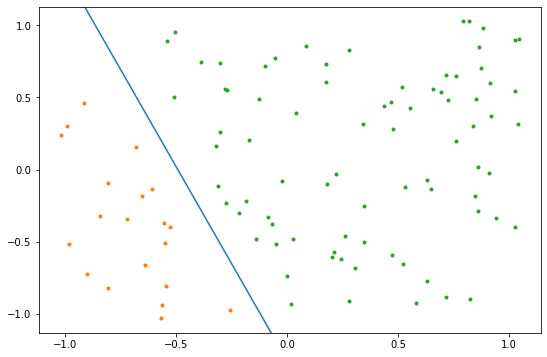

In [19]:
def separating_hyperplane(X, Y):
    n, N = X.shape

    # BEGIN SOLUTION
    a = cp.Variable(n)
    b = cp.Variable()
    t = cp.Variable(pos=True)

    objective = cp.Maximize(t)
    constraints = [cp.multiply(Y, (a @ X - b)) >= t, cp.norm(a) ** 2 <= 1]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    if np.linalg.norm(a.value) > 0.5:
        return a.value, b.value, t.value
    else:
        return None, None, None
    # END SOLUTION


a_true = np.array([1, 0.4])
b_true = -0.5
X, Y = gen_separable_data(a_true, b_true, separation_factor=0.1)

a, b, t = separating_hyperplane(X, Y)

plot_separating_hyperplane2D(X, Y, a, b)

In [20]:
def tests_1():
    np.random.seed(179)
    for a_true, b_true in (
        (np.array([1, 1]), 0.1),
        (np.array([1, 2]), 1),
        (np.array([1, 1, 1]), 0),
    ):
        X, Y = gen_separable_data(a_true, b_true, N=1000, separation_factor=1)
        a, b, t = separating_hyperplane(X, Y)

        def cos_distance(x, y):
            return np.abs(np.dot(x, y)) / (np.linalg.norm(x) * np.linalg.norm(y))

        assert (
            np.abs(np.min(Y * (a @ X - b)) - t) < 1e-6
        ), "`t` is not the minimal distance to the hyperplane"
        assert (
            1 - cos_distance(a, a_true) < 1e-3
        ), "Angle between true hyperplane and computed hyperplane is too big"
    X, Y = gen_separable_data([1, 1], 0, separation_factor=-1)
    a, b, t = separating_hyperplane(X, Y)
    for var in (a, b, t):
        assert (
            var is None
        ), "If there is no separating hyperplane, then all variables should be `None`."


tests_1()

## Exercise 2: Robust solution with hinge loss

Next, we want to improve the SVM so that it finds 'the best' hyperplane in the case that the data is _not_ separable. We first rewrite the problem in three steps (convince yourself that these problems are all equivalent):
$$
\begin{array}{ll}
\text{maximize} & t \\
\text{subject to} &y_i(a^\top x_i/t-b/t)\geq 1,\qquad \forall i\\
& \|a\|_2^2\leq 1 \\ 
\end{array}
$$

$$
\begin{array}{ll}
\text{maximize} & t \\
\text{subject to} &y_i(a^\top x_i-b)\geq 1,\qquad \forall i\\
& \|a\|_2^2\leq 1/t \\ 
\end{array}
$$

$$
\begin{array}{ll}
\text{minimize} & \frac12 \|a\|_2^2 \\
\text{subject to} &y_i(a^\top x_i-b)\geq 1,\qquad \forall i
\end{array}
$$

Now we want to minimize the number of points on the wrong side of the hyperplane. If a point $x_i$ is on the wrong side of the hyperplane then
$$
    y_i(a^\top x_i -b) \leq 1,\qquad \Leftrightarrow 1-y_i(a^\top x_i-b)\geq 0.
$$

To penalize only those points on the wrong side of the hyperplane, we can therefore add a _hinge loss_ penalty $\max(0, 1-y_i(a^\top x_i-b))$. This gives the unconstrained problem
$$
\begin{array}{ll}
\text{minimize} & \frac12 \|a\|_2^2 +C\sum_{i=1}^N \max(0, 1-y_i(a^\top x_i-b))\\
%\text{subject to} &y_i(a^\top x_i-b)\geq 1,\qquad \forall i
\end{array}
$$

The constant $C>0$ determines how much we penalize misclassification, and we need to vary this depending on the problem that we are solving. The seperable case corresponds to $C=\infty$ (so no misclassification is allowed since this would give an infinite cost). Notice that $\xi_i=\max(0, 1-y_i(a^\top x_i-b))$ is the smallest number such that $y_i(a^\top x_i-b)\geq 1-\xi_i$. We can therefore rewrite the problem as:
$$
\begin{array}{ll}
\text{minimize} & \frac12 \|a\|_2^2 +C\sum_{i=1}^N \xi_i\\
\text{subject to} &y_i(a^\top x_i-b)\geq 1-\xi_i,\qquad \forall i\\
& \xi_i\geq 0
\end{array}
$$

Here, $\xi_i=0$ means that $x_i$ lies on the correct side of the hyperplane. If $\xi>0$ then it is equal to $1-y_i(a^\top x_i-b)$.

___  

> Write a function `SVM_primal(X, Y, C=1.0)` that solves this problem, and accepts the value of $C$ as an optional parameter. It should return the optimal value of `(a,b,xi)` in a tuple.

___

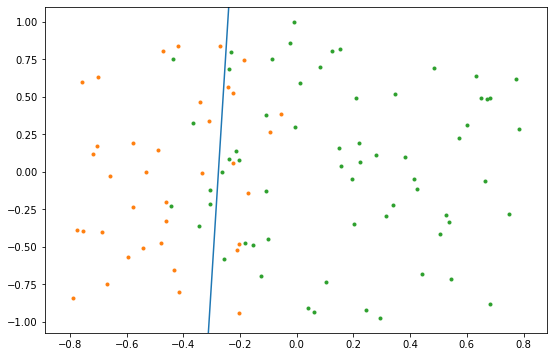

In [21]:
def SVM_primal(X, Y, C=1.0):
    n, N = X.shape

    # BEGIN SOLUTION

    xi = cp.Variable(N, pos=True)
    a = cp.Variable(n)
    b = cp.Variable()

    objective = cp.Minimize(cp.norm(a) ** 2 + C * cp.sum(xi))
    constraints = [cp.multiply(Y, (a @ X - b)) >= 1 - xi]

    problem = cp.Problem(objective, constraints)
    problem.solve()

    return a.value, b.value, xi.value

    # END SOLUTION


a_true = np.array([2, 0])
b_true = -0.5
X, Y = gen_separable_data(a_true, b_true, separation_factor=-0.2)

a, b, xi = SVM_primal(X, Y, C=50)

plot_separating_hyperplane2D(X, Y, a, b)

In [22]:
def tests_2():
    np.random.seed(179)
    for C in [10, 100]:
        for a_true, b_true in (
            (np.array([1, 1]), 0.1),
            (np.array([1, 2]), 1),
            (np.array([1, 1, 1]), 0),
        ):
            X, Y = gen_separable_data(a_true, b_true, N=1000, separation_factor=-0.1)
            a, b, xi = SVM_primal(X, Y, C=C)

            def cos_distance(x, y):
                return np.abs(np.dot(x, y)) / (np.linalg.norm(x) * np.linalg.norm(y))

            assert (
                1 - cos_distance(a, a_true) < 1e-3
            ), "Angle between true hyperplane and computed hyperplane is too big"

            assert np.all(
                Y * (a @ X - b) >= 1 - 1e4 - xi
            ), "The constraint is not satisfied"


tests_2()

## Exercise 3: The dual problem

For SVM it turns out that the dual problem is a QP. In general, QPs are easier to solve than SOCPs, like the primal problem. Recall that the primal problem is
$$
\begin{array}{ll}
\text{minimize} & \frac12 \|a\|_2^2 +C\sum_{i=1}^N \xi_i\\
\text{subject to} &y_i(a^\top x_i-b)\geq 1-\xi_i,\qquad \forall i\\
& \xi_i\geq 0
\end{array}
$$

The Lagrangian is therefore
$$
L(a,b,\xi,\mu,\nu) = \frac 12 \|a\|^2 + C\sum_{i=1}^N\xi_i - \sum_{i=1}^N \mu_i\left(y_i(a^\top x_i-b) - (1-\xi_i)\right) -\sum_{i=1}^N\nu_i\xi_i.
$$

Let's rewrite this to
$$
   L(a,b,\xi,\mu,\nu) =\frac 12 \|a\|^2 - \sum_{i=1}^N \mu_iy_i(a^\top x_i)+\sum_{i=1}^N \mu_iy_ib+ \sum_{i=1}^N\xi_i(C-\mu_i-\nu_i)  + \sum_{i=1}^N\mu_i.
$$

We compute the partial derivatives with respect to $a,b,\xi$ and set them to zero.  

- $\frac{\partial L}{\partial a}=0$ gives $a=\sum_i\mu_i y_ix_i$.  

- $\frac{\partial L}{\partial b}=0$ gives $\sum_i\mu_iy_i=0$, this kills the term depending on $b$.

- $\frac{\partial L}{\partial \xi_i}=0$ gives $C-\mu_i-\nu_i=0$ for all $i$, this kills the term depending on $\xi$. 

- If $\mu_i<0$ or $\nu_i<0$ the Lagrangian is unbounded below. Together with $C-\mu_i-\nu_i=0$ this also gives $0\leq \mu_i\leq C$.

Substituting $a=\sum_i\mu_i y_ix_i$ means that the first and second term are the same up to a scalar factor. The 3rd, 4th and 5th term dissappear when minimizing the Lagrangian. The Lagrangian also no longer depends on $\nu$. This gives dual problem
$$
\begin{array}{ll}
\text{maximize} & \sum_{i=1}^N\mu_i - \frac12 \sum_i\sum_j \mu_iy_i x_i^\top x_j y_j \mu_j \\
\text{subject to} & 0\leq \mu_i\leq C\\
& y^\top \mu = 0
\end{array}
$$

If we write the data and the labeled together as $Z = (y_1x_1,\dots,y_Nx_N)\in\mathbb R^{n\times N}$, then the second term in the objective becomes $\mu^\top Z^\top Z \mu = \|Z\mu\|^2$. Thus we get the QP
$$
\begin{array}{ll}
\text{minimize} & \frac12\|Z\mu\|^2-\mathbf{1}^\top\mu\\
\text{subject to} & 0\leq \mu_i\leq C\\
& y^\top \mu = 0
\end{array}
$$

### Exercise 3a)

> Write the function `SVM_dual(X,Y,C=1.0)` solving the SVM problem. It should return the optimal values $\mu$.

___  

If you get `SolverError` while running the code, pass the `solver='ECOS'` keyword argument to `problem.solve()`; for more information, see the remark below.

In [23]:
def SVM_dual(X, Y, C=1.0):
    n, N = X.shape
    Z = X * Y

    # BEGIN SOLUTION

    mu = cp.Variable(N)
    objective = cp.Minimize(cp.sum_squares(Z @ mu) / 2 - cp.sum(mu))
    constraints = [mu >= 0, mu <= C, mu @ Y == 0]

    problem = cp.Problem(objective, constraints)
    problem.solve(solver="ECOS")

    return mu.value

    # END SOLUTION


X, Y = gen_separable_data(a_true, b_true, N=10, separation_factor=-0.2)
C = 100
mu = SVM_dual(X, Y, C=C)
mu

array([ 1.50376917e+01,  6.11575826e-09, -1.42116756e-10,  2.44297512e-09,
        7.76718234e+00,  7.27050950e+00, -8.35175401e-11, -4.41268039e-10,
        6.37817278e-08,  4.58286490e-08])

In [24]:
# write tests
def tests_3a():
    np.random.seed(179)
    for C in [10, 100]:
        for a_true, b_true in (
            (np.array([1, 1]), 0.1),
            (np.array([1, 2]), 1),
            (np.array([1, 1, 1]), 0),
        ):
            X, Y = gen_separable_data(a_true, b_true, N=1000, separation_factor=-0.1)
            mu = SVM_dual(X, Y, C=C)

            def cos_distance(x, y):
                return np.abs(np.dot(x, y)) / (np.linalg.norm(x) * np.linalg.norm(y))

            assert (
                1 - cos_distance(a_true, (X * Y) @ mu) < 1e-3
            ), "Angle between true hyperplane and computed hyperplane is too big"

            assert np.all(-1e-4 <= mu), "The constraint is not satisfied"

            assert np.all(mu <= C * 1.001), "The constraint is not satisfied"

            assert np.abs(mu @ Y) < 1e-4, "The constraint is not satisfied"


tests_3a()

**REMARK**

> While the dual is a QP and the primal is an SOCP, surprisingly CVXPY solves the dual more slowly. This is because the solver called by CVXPY converts the objective to the standard form $\frac12\mu^\top (Z^\top Z)\mu - 1^\top \mu$, but $Z^\top Z$ is an $N\times N$ matrix, which is potentially huge. Machine learning libraries implementing SVM's use an iterative algorithm specialized for the particular QP appearing in an SVM. [Read more about this algorithm on Wikipedia](https://en.wikipedia.org/wiki/Sequential_minimal_optimization)

After solving the dual problem, we can use the formula $a=\sum_{i=1}^N\mu_ix_iy_i=Z\mu$ to recover the optimal value of $a$ from the optimal values of $\mu$. Moreover we note that only the points with $\mu_i>0$ contribute to the hyperplane $a$. Vectors $x_i$ with $\mu_i>0$ are called _support vectors_, and they are the reason for the name _support vector machine_.

The offset $b$ can also be recovered from the dual solution $\mu$. The support vectors are divided into two classes, those where $0<\mu_i<C$ are called _on the margin_, and those where $\mu_i=C$ are _in the margin_. The feasibility conditions of the primal Lagrangian include the condition $\nu_i\xi_i=0$ for all $i$, hence $\xi_i=0$ if $\nu_i>0$. Since $\mu_i = C-\nu_i$, we have that $\nu_i>0$ precisely if $\mu_i<C$. Recall that at an optimal point $y_i(a^\top x_i-b)\leq 1-\xi_i$, and for points _on the margin_ ($0<\mu_i<C$) we precisely have $y_i(a^\top x_i-b)=1$. These points can thus be used to recover $b$. There is a range of values of $b$ that would work. So in practice we take the _mean_ of $a^\top x_i-y_i$ for all $x_i$ that lie on the margin to determine $b$.

### Exericse 3b)

> Write a function `SVM_primal_from_dual(X,Y,mu,C)` that outputs the optimal parameters $(a,b)$ of the primal problem given the solution $\mu$ to the dual problem. 

___

Tips:  

- Due to floating point errors we rarely exactly have $\mu_i=0$ or $\mu_i=C$. You can detect $0<\mu_i<C$ by checking $\mu_i>10^{-6}$ and $\mu_i < 0.99  C$, for example. 

- To get a boolean array with `True` if $a<x<b$ we can use `(a<x) & (x<b)`.

- Recall that we can use boolean arrays for indexing. For example `Y[mu==0]` is equivalent to `np.array([Y[i] for i in range(len(Y)) if mu[i]==0])`.

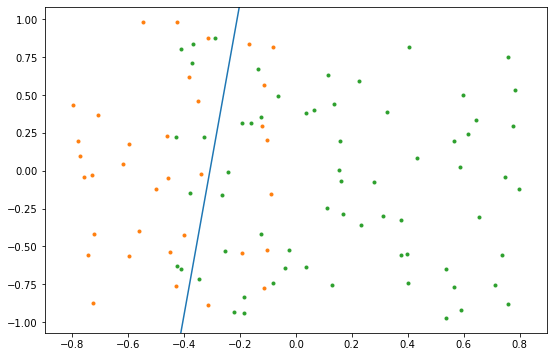

In [25]:
def SVM_primal_from_dual(X, Y, mu, C):
    # BEGIN SOLUTION

    Z = X * Y
    a = Z @ mu

    margin_points = (mu > 1e-6) & (mu < C * 0.99)
    b = np.mean(np.dot(a, X[:, margin_points]) - Y[margin_points])

    return (a, b)

    # END SOLUTION


def mu_sklearn(X, Y, C):
    """Function to compute mu if 3a isn't solved"""
    from sklearn.svm import SVC

    svc = SVC(C=C, kernel="linear")
    svc.fit(X.T, Y)
    mu = np.zeros(len(Y)) + np.random.uniform(-1e-13, 1e-13, size=len(Y))
    mu[svc.support_] += np.abs(svc.dual_coef_)[0]
    return mu


X, Y = gen_separable_data(a_true, b_true, separation_factor=-0.2)
C = 100
try:
    mu = SVM_dual(X, Y, C)
except:
    print(
        "Code for exercise 3a gave an error, we compute `mu` with `sklearn.svm.svc` instead"
    )
    mu = mu_sklearn(X, Y, C)

a, b = SVM_primal_from_dual(X, Y, mu, C)
plot_separating_hyperplane2D(X, Y, a, b)

In [26]:
# write tests
def tests_3b():
    from sklearn.svm import SVC

    np.random.seed(179)
    for C in [10, 100]:
        for a_true, b_true in (
            (np.array([1, 1]), 0.1),
            (np.array([1, 2]), 1),
            (np.array([1, 1, 1]), 0),
        ):
            X, Y = gen_separable_data(a_true, b_true, N=1000, separation_factor=-0.1)
            svc = SVC(C=C, kernel="linear")
            svc.fit(X.T, Y)
            mu = np.zeros(len(Y)) + np.random.uniform(-1e-13, 1e-13, size=len(Y))
            mu[svc.support_] += np.abs(svc.dual_coef_)[0]

            a, b = SVM_primal_from_dual(X, Y, mu, C)

            def cos_distance(x, y):
                return np.abs(np.dot(x, y)) / (np.linalg.norm(x) * np.linalg.norm(y))

            assert (
                1 - cos_distance(a, svc.coef_[0]) < 1e-3
            ), "Angle between true hyperplane and computed hyperplane is too big"

            assert svc.intercept_ + b < 1e-3, "The offset `b` is incorrect"


tests_3b()

## Exercise 4: The kernel trick

Recall that the dual is of the form
$$
\begin{array}{ll}
\text{minimize} & \frac12 \mu^\top (Z^\top Z)\mu-\mathbf{1}^\top\mu\\
\text{subject to} & 0\leq \mu_i\leq C\\
& y^\top \mu = 0
\end{array}
$$

where $(Z^\top Z)_{ij} = \langle x_i,\, x_j\rangle y_iy_j$. Thus to solve the dual problem we only need to be able to compute inner products between the data vectors and the labels. We can use this to fit more complicated decision boundaries than hyperplanes by applying a nonlinear function $\phi\colon \mathbb R^n\to \mathbb R^{m}$ to our data. Then, as decision boundary we can use 
$$
a^\top \phi(x) \leq b
$$

with $a\in \mathbb R^m$ and $b\in \mathbb R$. The boundary is a non-linear hypersurface in $\mathbb R^n$. Another way to interpret this is to regard $\phi(x)$ as an enrichment or transformation of the original data.

For example, for 2D data, we can use a conic section as decision boundary in 2D by mapping $\phi(s,t)= (1, \sqrt{2}s,\sqrt{2}t,s^2,t^2,\sqrt{2}st)$. Since we only need to compute inner products of points, we never need to compute $\phi(s,t)$ explicitly since
$$
\begin{align}
    \langle \phi(s,t) ,\,\phi(s',t')\rangle &= \langle (1, \sqrt{2}s,\sqrt{2}t,s^2,t^2,\sqrt{2}st),\,(1, \sqrt{2}s',\sqrt{2}t',{s'}^2,{t'}^2,\sqrt{2}s't')\rangle \\ 
    &= 1+ 2ss'+2tt'+{s}^2{s'}^2+{t}^2{t'}^2+2sts't'\\
    &= (1+ss'+tt')^2
\end{align}
$$

More generally, to use a basis of degree $d$ polynomials in $\mathbb R^n$, we can define the symmetric _kernel_ matrix $K$ by
$$
    K_{ij} = \left(1+\langle x_i,\,x_j\rangle\right)^dy_iy_j.
$$

Another popular choice of kernel are _radial basis functions_ (RBF)  which corresponds to
$$
K_{ij} = \exp(-\gamma\|x_i-x_j\|^2)y_iy_j.
$$

In all cases, the transformed SVM leads to the problem
$$
\begin{array}{ll}
\text{minimize} & \frac12 \mu^\top K\mu-\mathbf{1}^\top\mu\\
\text{subject to} & 0\leq \mu_i\leq C\\
& y^\top \mu = 0
\end{array}
$$

This is known as the _kernel trick_, since we can model very complicated functions $\phi$ at the expense of only a little more computational power than 'classical' SVM's. Then from $\mu$ we can recover $a\in\mathbb R^m$ by computing 
$$
a = \sum_i y_i\phi(x_i)\mu_i.
$$

In practice $\mu_i$ is zero for the majority of data points, so this is not very expensive to compute. Similarly $b$ can now be obtained by averaging $a^\top\phi(x_i)-y_i$ for all points on the margin (i.e. $0<\mu_i<C$).

### Exercise 4a)

> Write a function `poly_kernel(X,Y,d)` that computes the kernel matrix corresponding to a polynomial embedding, i.e. $K_{ij} = (1+\langle x_i,\,x_j\rangle)^dy_iy_j$. 

___

Tips:

- To create a matrix containing all inner products $\langle x_i,\,x_j\rangle$ you can use $X^\top X$. You then need to just apply entry-wise operations to this matrix. In particular you need to multiply _entry wise_ by the matrix $yy^\top$.

In [27]:
def poly_kernel(X, Y, d):
    # BEGIN SOLUTION
    Z = X
    K = Z.T @ Z
    K = (1 + K) ** d
    return K * (Y.reshape(-1, 1) @ Y.reshape(1, -1))
    # END SOLUTION


X, Y = gen_separable_data(a_true, b_true, N=5)
poly_kernel(X, Y, 2)

array([[ 3.00388954,  0.72775611, -0.91308976,  1.70276804,  1.87421901],
       [ 0.72775611,  1.07264823, -0.88879797,  1.03313574,  0.97116252],
       [-0.91308976, -0.88879797,  2.8997487 , -0.02586814, -0.12154853],
       [ 1.70276804,  1.03313574, -0.02586814,  4.36280677,  3.57480872],
       [ 1.87421901,  0.97116252, -0.12154853,  3.57480872,  3.06525451]])

In [28]:
def tests_4a():
    for d in [2, 3]:
        for n in [2, 3]:
            X = np.ones((n, 100))
            Y = np.ones(100)
            K = poly_kernel(X, Y, d)
            assert (
                np.sum(np.abs(K - (n + 1) ** d)) < 1e-10,
                f"Incorrect result for n={n}, d={d}",
            )

            X, Y = gen_separable_data([1] * n, 0)
            K = poly_kernel(X, Y, d)
            assert np.linalg.norm(K.T - K) < 1e-5, "The kernel is not symmetric"
            for (i, j) in np.random.choice(100, size=(10, 2)):
                assert (
                    np.abs(K[i, j] - (1 + np.dot(X[:, i], X[:, j])) ** d) * Y[i] * Y[j]
                    < 1e-6
                ), f"Incorrect result for n={n}, d={d}"


tests_4a()

**REMARK**

> To compute $a$ from the optimal values $\mu$, we will still need a map $\phi$ giving the polynomial features. For degree $2$ this was easy to deduce, but for degree $d$ it is a bit tricky. The map $\phi$ should satisfy
$$
\left(1+\sum_{k=1}^n x_i[k]x_j[k]\right)^d = \left\langle\phi(x_i),\,\phi(x_j)\right\rangle
$$  

> Where $x_i[k]$ is the $k$th entry of $x_i$. If for convenience we define $x_i[0]=1$, then we can expand the left side using the multinomial theorem to 
$$
\sum_{m_0+\dots+m_n=d}\binom{d}{m_0,\dots,m_n}\prod_{k=0}^n x_i[k]^{m_k}x_j[k]^{m_k}
$$  

> with $m_\ell\geq 0$. From this expression we can deduce that $\phi$ is given by
$$
\phi(x_i) = \left(\left.\sqrt{\binom{d}{m_0,\dots,m_n}}\prod_{k=1}^n x_i[k]^{m_k} \,\right|\,m_0+\dots+m_n=d\right)
$$  

> We can generate a list of all multinomial coefficients using the `sympy` library, specifcally the function [sympy.ntheory.multinomial_coefficients](https://docs.sympy.org/latest/modules/ntheory.html#sympy.ntheory.multinomial.multinomial_coefficients)

In [29]:
def polynomial_features(X, d):
    """Computes the polynomial features of degree `d` with correct multinomial coefficients.
    Here `X` is an array of shape `(n,N)`, with `N` the number of data points and `n` the dimensionality.
    """
    n = X.shape[0]

    # Generate list of all powers of X
    X_powers = np.stack([X ** i for i in range(d + 1)])

    # Get all multinomial coefficients
    # Store tuples (m_1,...,m_n) in array `powers` (m_0 is ignored)
    # Store coefficients in `coeffs` and take square root.
    multinomial = sympy.ntheory.multinomial_coefficients(n + 1, d)
    powers = np.array(list(multinomial.keys()))
    powers = powers[:, 1:]
    coeffs = np.sqrt(np.array(list(multinomial.values()), float))

    # Compute the product x_i[k]^{m_k} for each data point, and each tuple (m_1,..,m_n)
    # Multiply result by the square roots of multinomial coefficients
    features = np.prod([X_powers[powers[:, i], i] for i in range(n)], axis=0).T
    features = coeffs * features
    return features.T


def plot_poly_hypersurface(X, Y, a, b, d, N_points_contour=20):
    plt.figure(figsize=(10, 10))
    plt.plot(X[0][Y == -1], X[1][Y == -1], ".")
    plt.plot(X[0][Y == 1], X[1][Y == 1], ".")
    plt.ylim(np.min(X[1]) - 0.1, np.max(X[1]) + 0.1)
    plt.xlim(np.min(X[0]) - 0.1, np.max(X[0]) + 0.1)

    xx, yy = np.meshgrid(
        np.linspace(np.min(X[0]) - 0.1, np.max(X[0]) + 0.1, N_points_contour),
        np.linspace(np.min(X[1]) - 0.1, np.max(X[1]) + 0.1, N_points_contour),
    )
    xxyy = np.stack([xx, yy]).reshape(2, -1)
    values = a @ polynomial_features(xxyy, d) - b
    values = values.reshape(xx.shape)
    plt.contour(xx, yy, values, [0], c="r")

### Exercise 4b)

> Write a function `SVM_poly(X,Y,d,C=1.0)` that solves the SVM problem using the kernel trick with a polynomial kernel of degree $d$. The function should return the values for $(a,b)$ in a tuple.

___

Tips:

- Use [cp.quad_form](https://www.cvxpy.org/api_reference/cvxpy.atoms.other_atoms.html#quad-form) for the expression $\mu^\top K\mu$.

- Use `polynomial_features(X,d)` to compute $\phi(x_i)$ needed for the formula $a=\sum_{i=1}^Ny_i\phi(x_i)\mu_i$. This is also needed for computing the offset $b=\mathbb E[a^\top x -y\mid0<\mu<C]$

- If you did not solve the previous exercise, you can instead use `K=Z.T@Z` with `Z = polynomial_features(X,d)*Y` instead. (For low-dimensional data this is not much slower than the kernel trick, for high-dimensional data it matters a lot since the dimension of the polynomial embedding scales as $n^d$.)

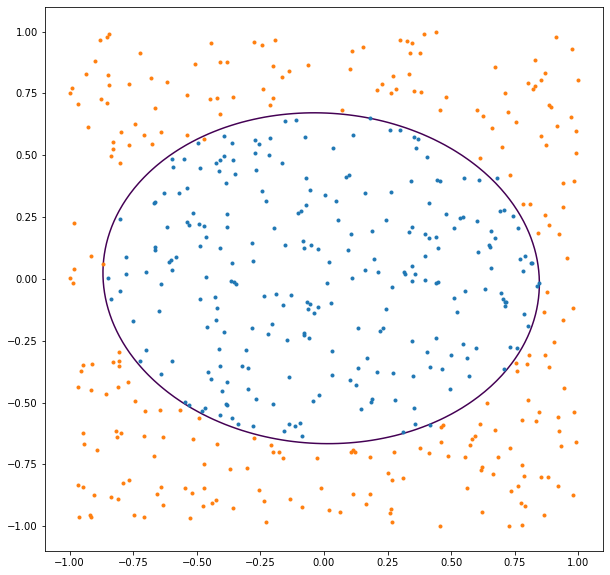

In [30]:
def SVM_poly(X, Y, d, C=1.0):
    n, N = X.shape

    # BEGIN SOLUTION

    K = poly_kernel(X, Y, d)

    # Alternative kernel, only feasible for low-dimensional data
    Z = polynomial_features(X,d)*Y
    K = Z@Z.T

    mu = cp.Variable(N)
    objective = cp.Minimize(cp.quad_form(mu, K) / 2 - cp.sum(mu))

    constraints = [mu >= 0, mu <= C, mu @ Y == 0]

    problem = cp.Problem(objective, constraints)
    problem.solve(solver="ECOS")

    mu = mu.value
    support = mu > 1e-6
    a = polynomial_features(X[:, support], d) @ (mu[support] * Y[support])

    margin_points = (mu > 1e-6) & (mu < C * 0.99)
    b = np.mean(
        np.dot(a, polynomial_features(X[:, margin_points], d)) - Y[margin_points]
    )

    return a, b
    # END SOLUTION
def SVM_poly(X, Y, d, C=1.0):
    n, N = X.shape
    K = poly_kernel(X,Y,d)
    mu = cp.Variable(N)
    o = np.ones(N)
    obj = cp.Minimize(1/2 * cp.quad_form(mu,K) - o.T@mu)
    const = [10**(-6)<=mu, mu<= 0.99*C, Y.T@mu == 0]
    Problem = cp.Problem(obj, const)
    Problem.solve(solver="ECOS")
    P = polynomial_features(X,d)
    Z = Y*P
    A = Z * mu.value
    a = np.sum(A,1)
    c = a.T@P - Y
    b = np.mean(c[(mu.value>10**(-6))&(mu.value<0.99*C)])
    return (a,b)

d = 2
N = 500
X = np.random.uniform(-1, 1, (2, N))
(s1, s2) = np.random.uniform(-1, 1, 2)
F = s1 * X[0] ** 2 + s2 * X[1] ** 2
Y = F < np.median(F)
Y = Y.astype(int) * 2 - 1
a, b = SVM_poly(X, Y, d, 100)

plot_poly_hypersurface(X, Y, a, b, d, N_points_contour=100)

In [31]:
def tests_4b():
    np.random.seed(179)

    def classification_error(X, Y, a, b, d):
        return np.mean((a @ polynomial_features(X, d) - b > 0) != (Y == 1))

    for d in [1, 2, 3]:
        for n in [2, 3, 4]:
            N = 100
            X = np.random.uniform(-1, 1, (n, N))
            F = np.sum((np.random.uniform(-1, 1, n) * X.T) ** d, axis=1)
            Y = F < np.median(F)
            Y = Y.astype(int) * 2 - 1

            a, b = SVM_poly(X, Y, d, 100)
            error = classification_error(X, Y, a, b, d)
            if n == 2:
                assert error < 0.1, "Classfication error is too big"
            else:
                assert error < 0.5, "Classfication error is too big"


tests_4b()